In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda


In [6]:

# os.chdir('C:/FAE')
os.chdir('C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/FDA_python')
if not os.getcwd() in sys.path:
    sys.path.append(os.getcwd())
import DataGenerator
from DataGenerator import *
import DataGenerator_NN
from DataGenerator_NN import *
import Functions
from Functions import *


In [7]:
help(DataGenerator)

Help on function DataGenerator in module DataGenerator:

DataGenerator(nc=250, tpts=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), classes=4, noise=2)
    # nc: number of data points per *class*, classes: number of classes/cluster, noise:std of the normal noise



In [8]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")


c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

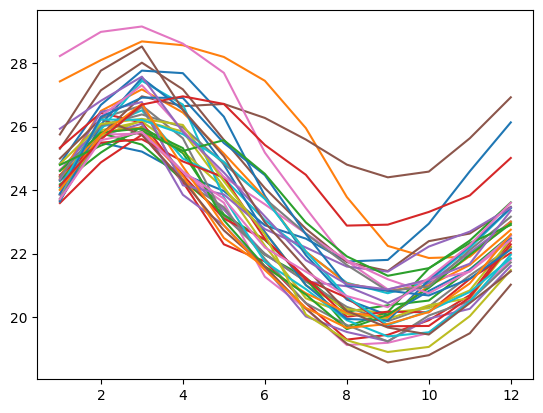

In [9]:
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
plt.show(
)

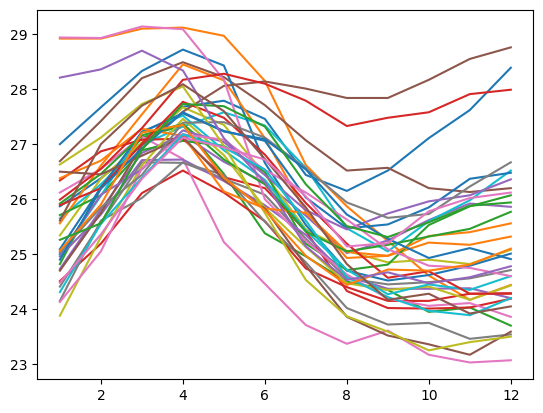

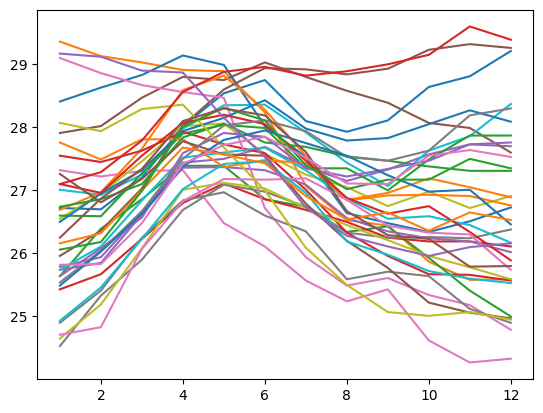

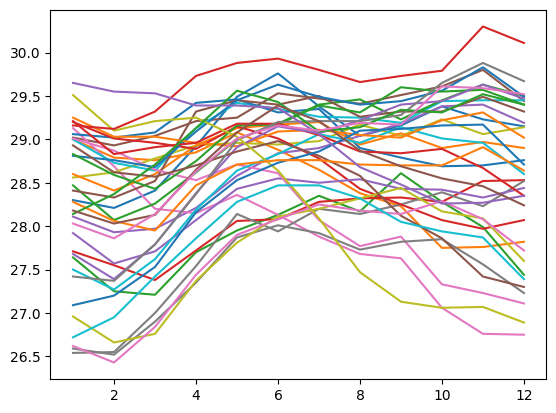

In [10]:
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
plt.show(

)
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
plt.show(
)


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
plt.show(
)

In [11]:
grid_points=ElNino_OISST_region_1and2_x
[ElNino_OISST_region_1and2_y.shape,

print("grid_points=",grid_points)]

grid_points= [ 1  2  3  4  5  6  7  8  9 10 11 12]


[(12, 37), None]

In [12]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

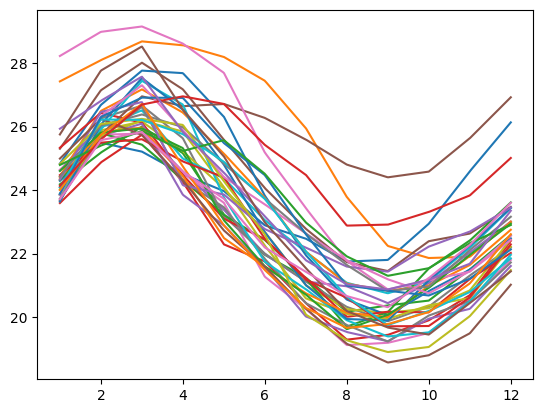

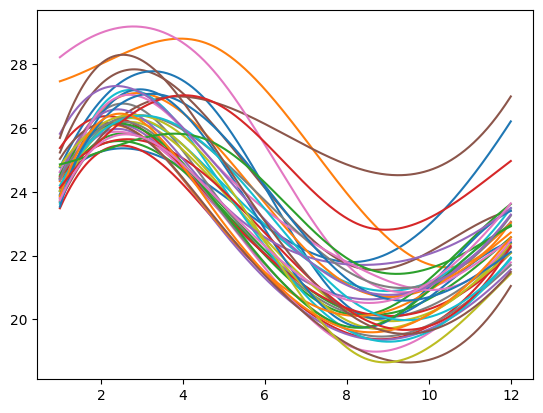

In [13]:
fd=skfda.FDataGrid(torch.t(torch.tensor(ElNino_OISST_region_1and2_y)),grid_points=ElNino_OISST_region_1and2_x)
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
fd_basis=fd.to_basis(basis=basis)
fd.plot()
fd_basis.plot()
plt.show()

On choisi le lissage par Bspline dont la base est déterminée par les noeuds linspace(1,12,4) et un order 4 d'interpolation.
Le nombre de basis est donc égale à :
(4+4-2)=6 



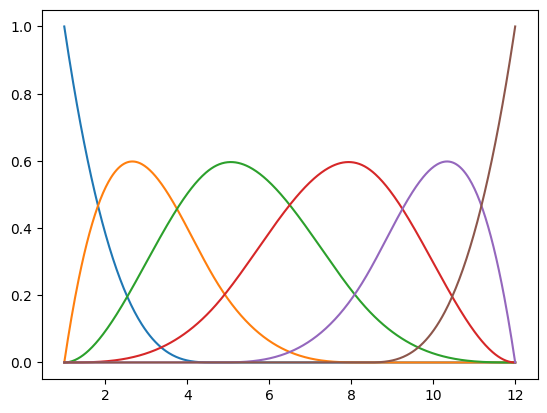

In [14]:
basis.plot()

In [15]:
class CNN_FAE(nn.Module):
    def __init__(self,n_basis=6):
        super(CNN_FAE,self).__init__()

            
        self.CNN_Conv=nn.Sequential(    
            nn.Conv1d(1,64,kernel_size=5,stride=[1],padding=[1],bias =True,dilation=1),
            
        )    
        self.Linear=nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(640,64),
            nn.LeakyReLU(0.15,inplace=True),
            nn.Linear(64,6)
        )
    
    def Revert(self, x, basis_fc):
        g = torch.matmul(basis_fc,torch.t(x))
        return g

    def Project(self, x, basis_fc):
        # basis_fc: n_time X nbasis
        # x: n_subject X n_time
        w = x.size(1)-1
        W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
        f = torch.matmul(torch.t(basis_fc),torch.mul(x, W.cuda()))
    
        return f

    def forward(self,functions):

        conv_out=self.CNN_Conv(functions)
        Linear_out=self.Linear(conv_out)
        revert_out=self.Revert(torch.tensor(basis_fc).float().cuda(),Linear_out)
        
                
                
        return Linear_out.float()

In [16]:
x =torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
w = x.size(1)-1
W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
W
x.size()
basis


BSplineBasis(domain_range=((1.0, 12.0),), n_basis=6, order=4, knots=(1.0, 4.666666666666666, 8.333333333333332, 12.0))

In [17]:

FD_grid_region_1and_2=skfda.representation.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
FD_grid_region_3=skfda.representation.FDataGrid(x1.detach().cpu(),grid_points=ElNino_OISST_region_3_x)
FD_grid_region_4=skfda.representation.FDataGrid(x2.detach().cpu(),grid_points=ElNino_OISST_region_4_x)
FD_grid_region_3and_4=skfda.representation.FDataGrid(x3.detach().cpu(),grid_points=ElNino_OISST_region_3and4_x)

##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.


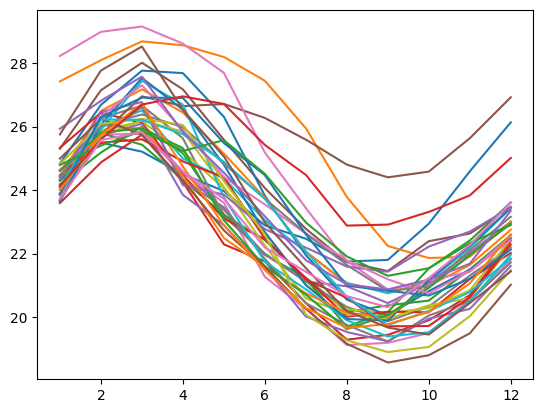

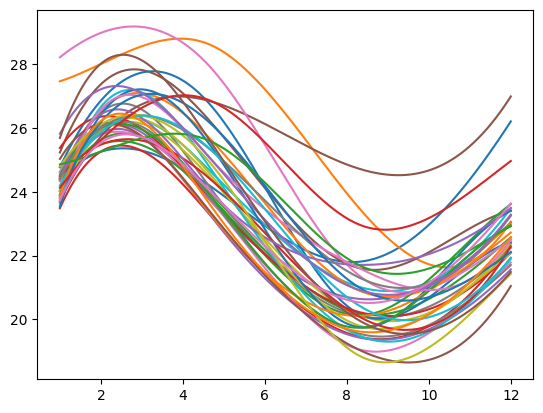

In [18]:

skfda.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x).plot()
plt.show()
FD_grid_region_1and_2.to_basis(basis).plot()
plt.show()

In [19]:
x0_transpose=x0.reshape(37,1,12)
x1_transpose=x1.reshape(37,1,12)
x2_transpose=x2.reshape(37,1,12)
x3_transpose=x3.reshape(37,1,12)


In [20]:

CNN=CNN_FAE()
CNN=CNN.cuda()
Conv_out=CNN.CNN_Conv(x0_transpose)
[x0.shape,Conv_out.shape]


[torch.Size([37, 12]), torch.Size([37, 64, 10])]

['conv_out shape=', torch.Size([37, 64, 10])]
0 0
Convlayer


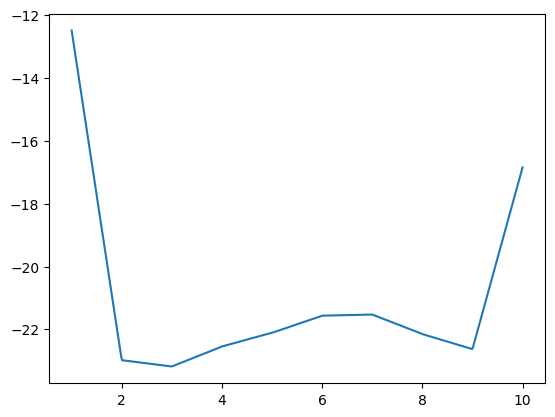

Smoothed convlayer


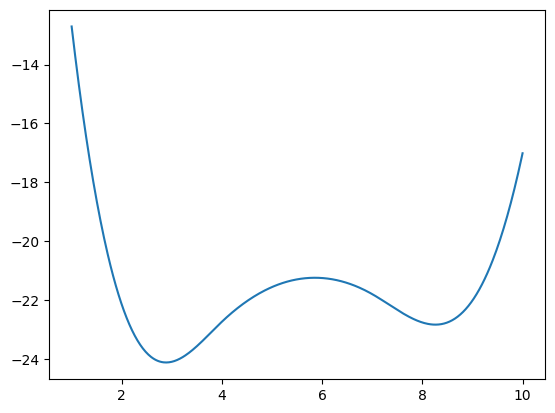

0 1
Convlayer


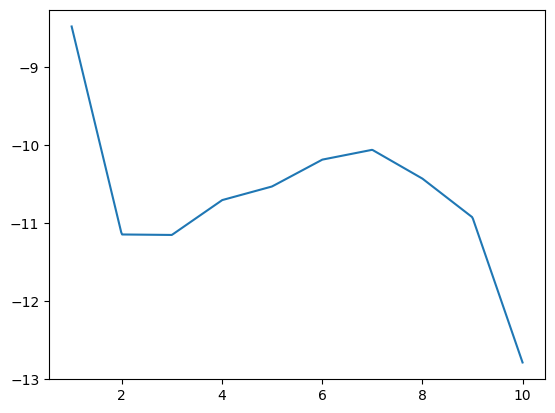

Smoothed convlayer


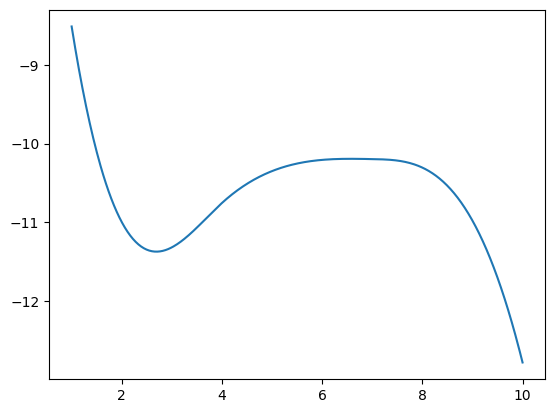

0 2
Convlayer


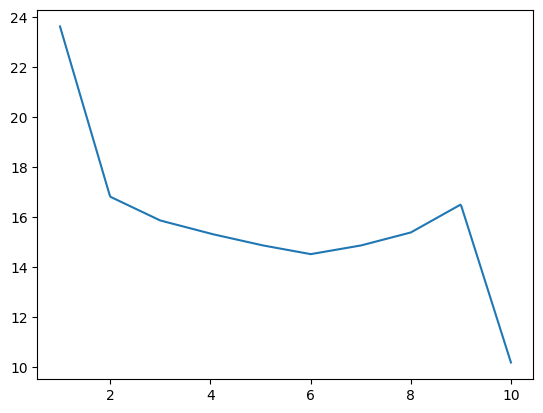

Smoothed convlayer


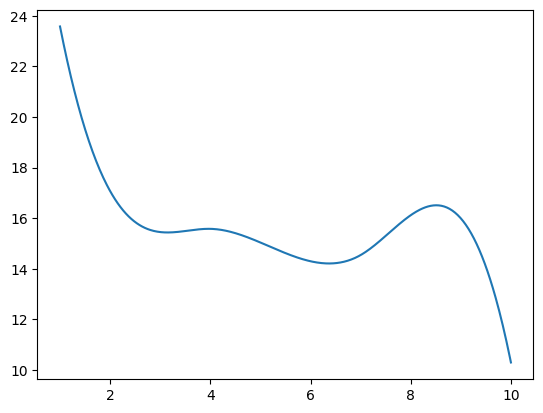

1 0
Convlayer


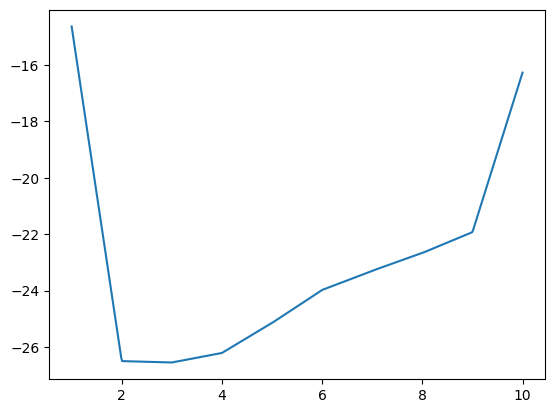

Smoothed convlayer


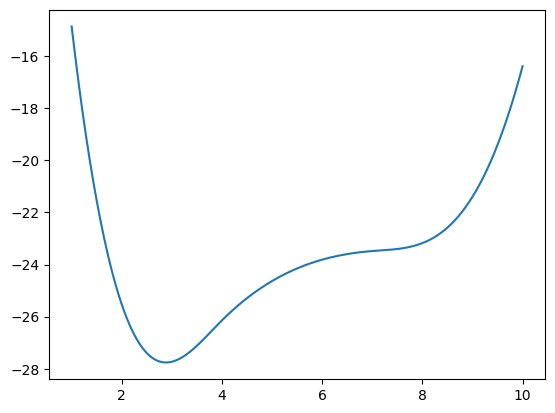

1 1
Convlayer


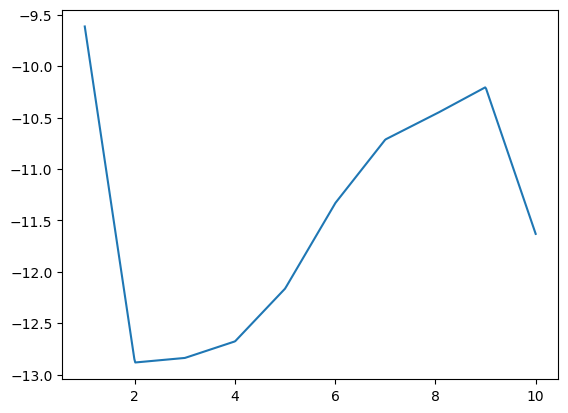

Smoothed convlayer


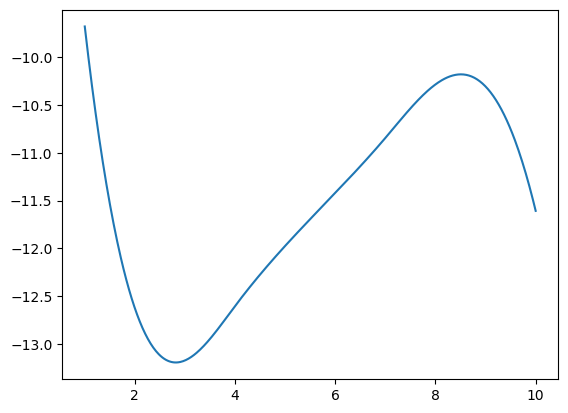

1 2
Convlayer


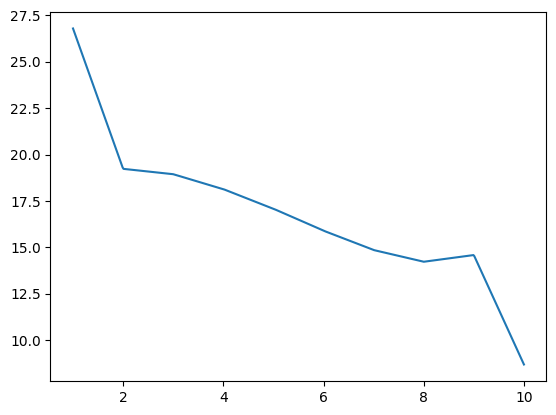

Smoothed convlayer


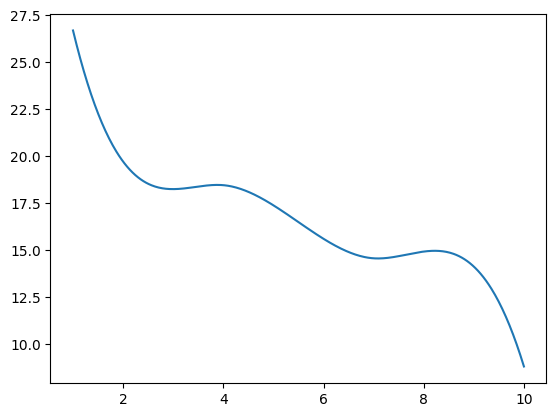

2 0
Convlayer


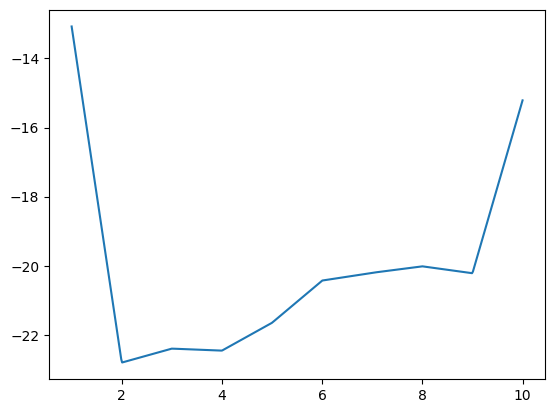

Smoothed convlayer


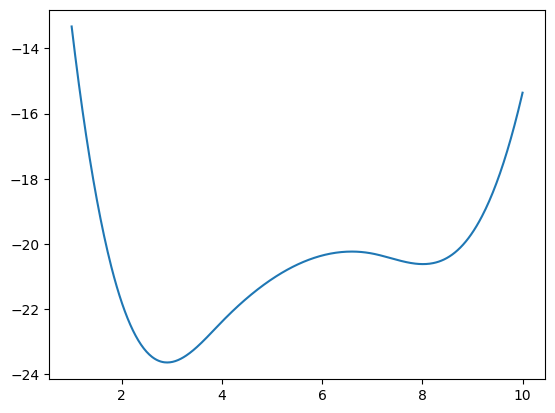

2 1
Convlayer


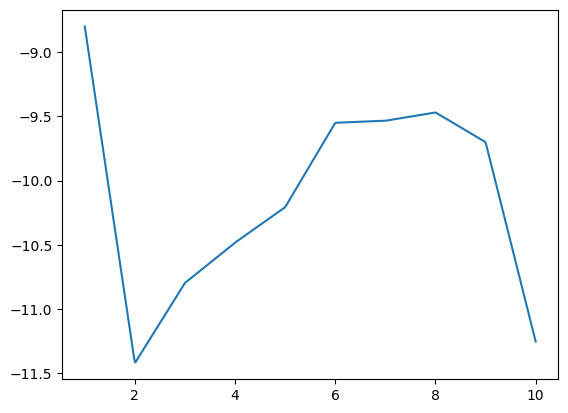

Smoothed convlayer


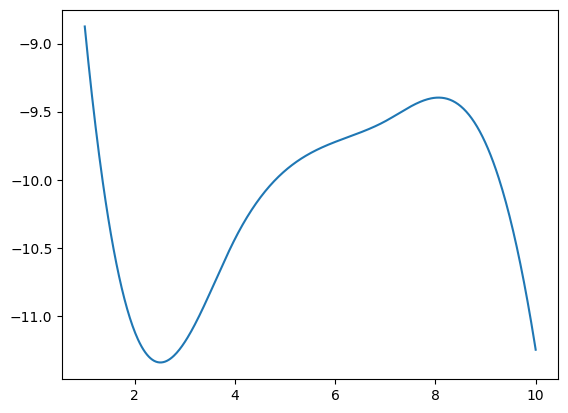

2 2
Convlayer


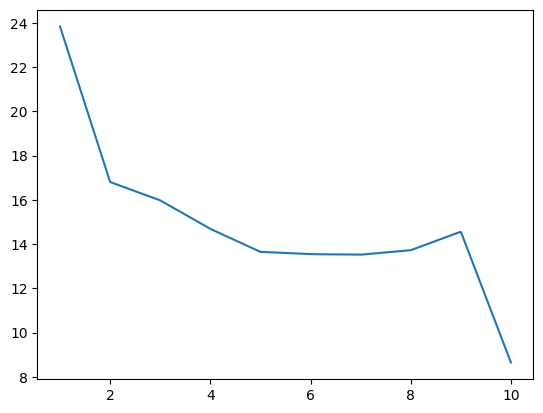

Smoothed convlayer


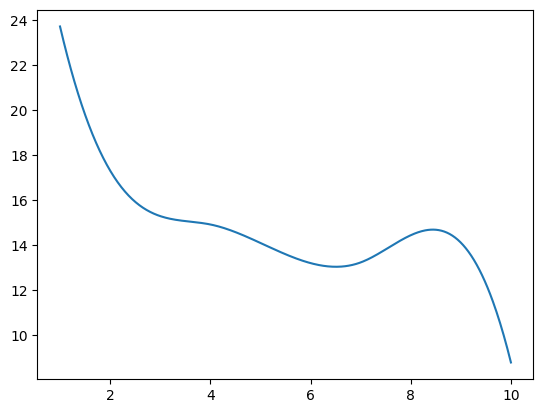

3 0
Convlayer


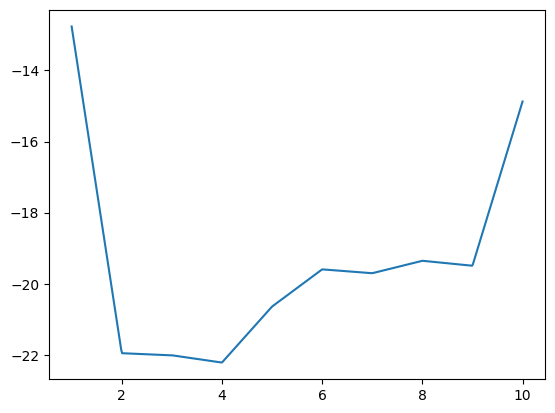

Smoothed convlayer


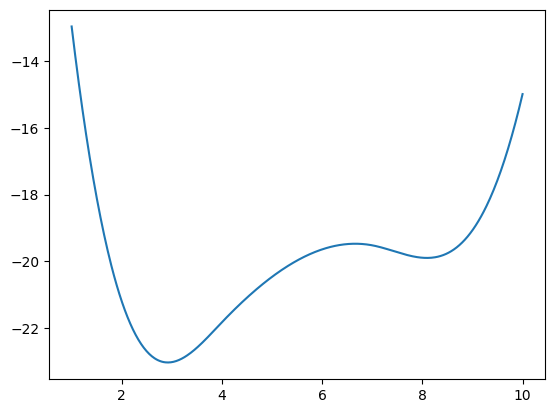

3 1
Convlayer


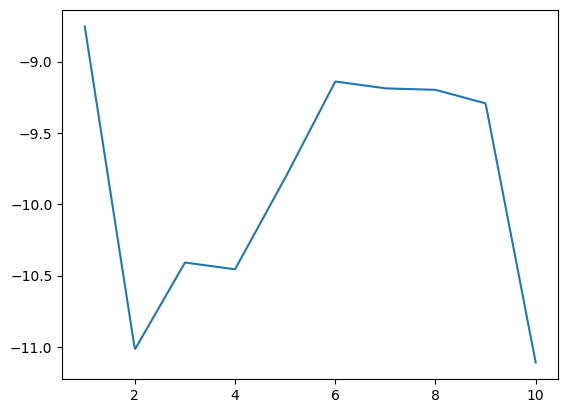

Smoothed convlayer


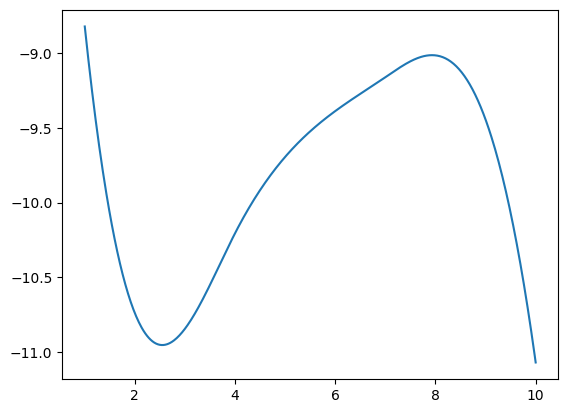

3 2
Convlayer


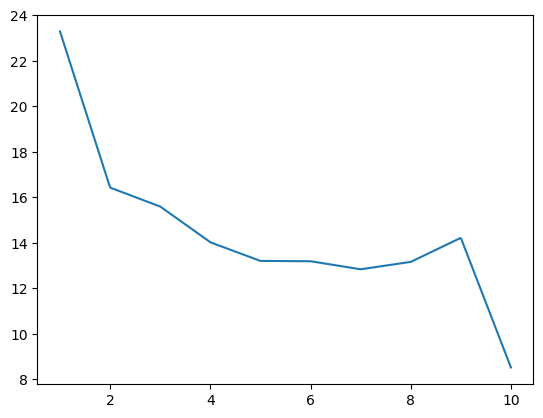

Smoothed convlayer


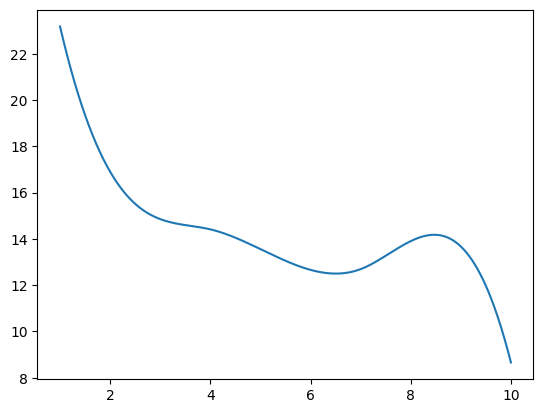

In [21]:

output_CNN_FAE=CNN.CNN_Conv(x0[1,:].unsqueeze(0))
n_conv_out=Conv_out.shape[2]
basis_conv_out=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_conv_out,4))
print(["conv_out shape=",Conv_out.shape])
Conv_out.shape
for i in range(4):
        for j in range(3):
            print(i,j)
            CNN.FD=skfda.FDataGrid(Conv_out[i,j,:].detach().cpu(),grid_points=linspace(1,n_conv_out,n_conv_out))
            print("Convlayer")
            CNN.FD.plot()
            plt.show()
            CNN.FD.to_basis(basis_conv_out).plot()
            print("Smoothed convlayer")
            plt.show()


In [22]:

Lin_out=CNN.Linear(Conv_out)
print(Lin_out.shape)
n_Linout=Lin_out.shape[1]



torch.Size([37, 6])


In [61]:
grid_points=ElNino_OISST_region_1and2_x
functions=x0
coef=skfda.FDataGrid(functions[:,:].detach().cpu(),grid_points=grid_points).to_basis(basis).coefficients

print(functions.shape)
Revert_manuel=torch.matmul(torch.tensor(coef).float().cuda(),torch.t(Lin_out.float()))
print("Revert_manuel_shape=",Revert_manuel.shape,)

torch.Size([37, 12])
Revert_manuel_shape= torch.Size([37, 37])


In [62]:

Basis_reconstruction=skfda.representation.basis.FDataBasis(basis=basis,coefficients=torch.t(Revert_manuel).detach().cpu())
Basis_reconstruction.plot()
plt.show()

ValueError: The length or number of columns of coefficients has to be the same equal to the number of elements of the basis.

In [703]:
CNN=CNN_FAE()
CNN=CNN.cuda()

In [30]:
basis_fc=FD_grid_region_1and_2.to_basis(basis).coefficients
out=CNN(x0_transpose)

out.shape,basis_fc.shape


(torch.Size([37, 6]), (37, 6))

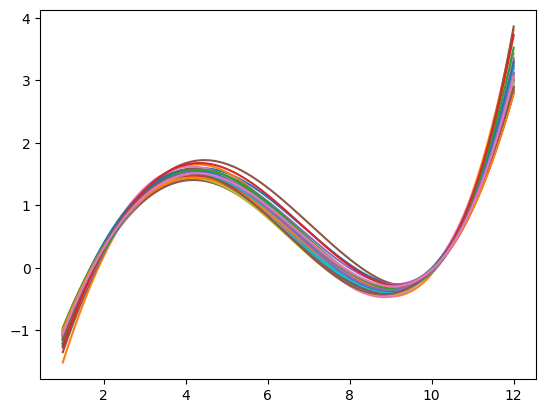

In [32]:
Basis_reconstruction=skfda.representation.basis.FDataBasis(basis=basis,coefficients=out.detach().cpu())
Basis_reconstruction.plot()
plt.show()

In [33]:

basis_train=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,n_conv_out,4),order=4)
coefs=skfda.FDataGrid(functions.detach().cpu(),grid_points=grid_points).to_basis(basis).coefficients
Revert_out=CNN.Revert(Lin_out.float(),basis_fc=torch.tensor(coef).float().cuda())
grid_output=skfda.FDataGrid(out.detach().cpu(),grid_points=grid_points)
print('Output du FAE de convolution avec couche Revert:')
grid_output.plot()
print(Revert_out.shape)

plt.show()




ValueError: Incorrect dimension in data_matrix and grid_points. Data has shape (6,) and grid points have shape [12]

In [35]:
n_output_CNN_FAE=out.shape
[CNN(x0_transpose).shape,
 n_output_CNN_FAE,
x0.shape]

[torch.Size([37, 6]), torch.Size([37, 6]), torch.Size([37, 12])]

In [36]:

basis_output_CNN_FAE=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput=skfda.FDataGrid(output.detach().cpu(),grid_points=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput.plot()
plt.show()
FDOutput.to_basis(basis=basis_output_CNN_FAE).plot()
plt.show()

TypeError: 'torch.Size' object cannot be interpreted as an integer

In [37]:
CNN=CNN_FAE()
CNN=CNN.cuda()

In [51]:
lr=0.001
betas=[0.5,0.999]
batch_size=5

loss_function=nn.MSELoss()
optimizer=optim.Adam(CNN.parameters(),lr=lr,betas=betas)
indice=np.arange(37)


#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)

In [56]:

from tqdm import tqdm
def train(n_epochs,x0):
    train_loss=torch.tensor(0).cuda()
    train_loader=torch.utils.data.DataLoader(x0,batch_size=batch_size)

    for i,functions_train in tqdm(enumerate(train_loader)):
        functions_train=functions_train.float().cuda()
        optimizer.zero_grad()
        output=CNN.Linear(CNN.CNN_Conv(functions_train))
        output=output.float().cuda()
        loss=loss_function(torch.tensor(basis_fc[batch_size*i:batch_size*(i+1)]).float().cuda(),output)
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.long()
    return train_loss,loss 

        


        


In [40]:

CNN(x0_transpose).shape

torch.Size([37, 6])

Reconstruction du lissage de X0

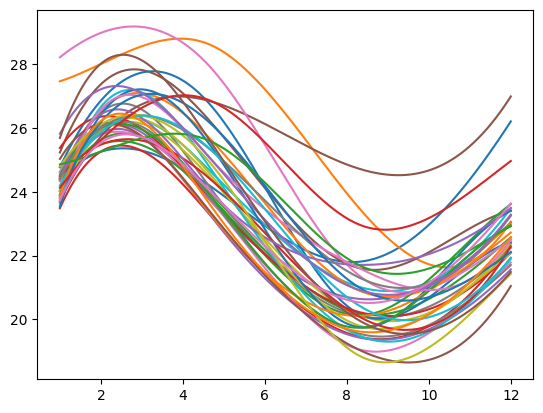

In [41]:
skfda.representation.basis.FDataBasis(basis=basis,coefficients= basis_fc).plot()
plt.show()

In [57]:
region_de_test=x0_transpose
train(1,region_de_test)


8it [00:00, 320.45it/s]


(tensor(20, device='cuda:0'),
 tensor(3.0006, device='cuda:0', grad_fn=<MseLossBackward0>))

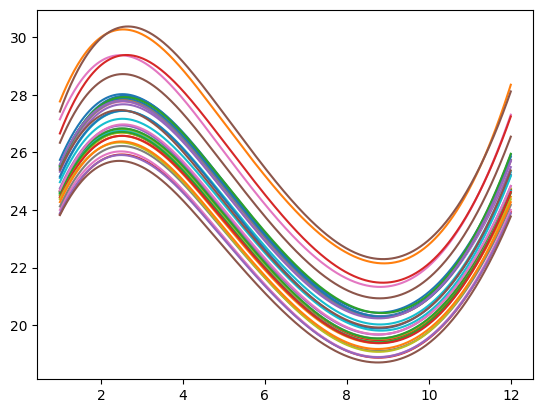

In [58]:
out=CNN(x0_transpose)
skfda.FDataBasis(basis=basis, coefficients=out.detach().cpu()).plot()
plt.show()

In [ ]:
import random
k=random.randint(1,37)
output=CNN(region_de_test[k,:].unsqueeze(0))
basis_output_CNN_FAE=skfda.representation.basis.BSplineBasis(knots=linspace(1,n_output_CNN_FAE,4))
FDOutput=skfda.FDataGrid(output.detach().cpu(),grid_points=linspace(1,n_output_CNN_FAE,n_output_CNN_FAE))
FDOutput.plot()
print("Ce que l'on recréer")
plt.show()
FDOutput_basis=FDOutput.to_basis(basis=basis_output_CNN_FAE)
FDOutput_basis.plot()
print("Smooth par B-Spline de ce que l'on a recréé")
plt.show()
FD_region_test=skfda.FDataGrid(region_de_test[k,:].detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
print("Ce que l'on est censé recréer")
FD_region_test.plot()
plt.show()
FD_region_test_basis=FD_region_test.to_basis(basis=basis)
FD_region_test_basis.plot()
print("Ce que l'on est censé recréer mais smooth")
plt.show()
FD_region_test.to_basis(basis=basis)==FDOutput.to_basis(basis=basis_output_CNN_FAE)

NameError: name 'CNN' is not defined

In [169]:
loss_function(region_de_test[k,:].float(),output)

c:\Users\Utilisateur\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2.0545, device='cuda:0', grad_fn=<MseLossBackward0>)

In [170]:
loss_function(torch.tensor(FDOutput_basis.coefficients).cuda(),torch.tensor(FD_region_test_basis.coefficients).cuda())

tensor(3.7538, device='cuda:0', dtype=torch.float64)

In [15]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

29131